In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from keras import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import keras.backend as K
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report
import math
from keras import backend as K
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import glob
import time
from tensorflow.keras.callbacks import *
from segmentation_models.metrics import f1_score, f2_score, iou_score, precision, recall
from segmentation_models.losses import jaccard_loss, dice_loss, binary_focal_loss, binary_crossentropy, bce_dice_loss, bce_jaccard_loss, binary_focal_dice_loss, binary_focal_jaccard_loss
import keras
import shutil
from keras import models
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [3]:
MODEL_NAME='U-Net with VGG16 Backbone'
IMG_SIZE=256
N_SPLITS=5
CHANNELS=1
LEARNING_RATE=1e-3
BATCH_SIZE=32
CLASSES=1
EPOCHS=200
ACTIVATION='sigmoid'
ACTF='relu'
CROSSENTROPY='binary_crossentropy'
OPTIMIZER='Adam'
BACKBONE='vgg16'
SAVE_BEST_ONLY=True
RESCALE=True
AUGMENTATION=True
ROTATION_RANGE=15
SHIFT_LEFT_RANGE=-0.15
SHIFT_RIGHT_RANGE=0.15
SCALE_LEFT_RANGE=-0.1
SCALE_RIGHT_RANGE=0.1
HORIZONTAL_FLIP=True
VERTICAL_FLIP=False
PROBABILITY=0.5
SEED=42
FOLDNO=5

In [4]:
#def iou_coef(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    union = K.sum(y_true) + K.sum(y_pred) - intersection
#    iou = 1.0 * intersection / union
#    return iou

#def iou_loss(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    union = K.sum(y_true) + K.sum(y_pred) - intersection
#    iou = 1.0 * intersection / union
#    return 1 - iou

# data evalutate function
#def dice_coef(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

# data evalutate function
#def dice_coef_loss(y_true, y_pred):
#    y_true = K.flatten(y_true)
#    y_pred = K.flatten(y_pred)
#    intersection = K.sum(y_true * y_pred)
#    dice = (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
#    return 1 - dice

# data pre-processing function
# standardization of data
def data_std(X_train, X_test):
    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))

    X_train = (X_train - mean)/(std + 1e-7)
    X_test = (X_test - mean)/(std + 1e-7)

    return X_train, X_test

# plot history for accuracy
def plot_f1score(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['f1-score'])
        plt.plot(history['val_f1-score'])
        if title is not None:
            plt.title(title)

        plt.ylabel('F1-score')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/f1score_figure/f1score_'+str(foldno)+'.tif')

# plot history for accuracy
def plot_f2score(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['f2-score'])
        plt.plot(history['val_f2-score'])
        if title is not None:
            plt.title(title)

        plt.ylabel('F2-score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/f2score_figure/f2score_'+str(foldno)+'.tif')

# plot history for accuracy
def plot_iou(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['iou_score'])
        plt.plot(history['val_iou_score'])
        if title is not None:
            plt.title(title)

        plt.ylabel('IoU')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/iou_figure/iou_'+str(foldno)+'.tif')

# plot history for accuracy
def plot_acc(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/acc_figure/acc_'+str(foldno)+'.tif')

# plot history for loss
def plot_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/loss_figure/loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_jaccard_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['jaccard_loss'])
        plt.plot(history['val_jaccard_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('IoU Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/jaccard_loss_figure/jaccard_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_dice_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['dice_loss'])
        plt.plot(history['val_dice_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Dice Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/dice_loss_figure/dice_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_bce_dice_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_crossentropy_plus_dice_loss'])
        plt.plot(history['val_binary_crossentropy_plus_dice_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Crossentropy + Dice Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/bce_dice_loss_figure/bce_dice_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_bce_jaccard_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_crossentropy_plus_jaccard_loss'])
        plt.plot(history['val_binary_crossentropy_plus_jaccard_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Crossentropy + Jaccard Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/bce_jaccard_loss_figure/bce_jaccard_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_binary_focal_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_focal_loss'])
        plt.plot(history['val_binary_focal_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Focal Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/binary_focal_loss_figure/binary_focal_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_binary_focal_dice_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_focal_loss_plus_dice_loss'])
        plt.plot(history['val_binary_focal_loss_plus_dice_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Focal Loss + Dice Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/binary_focal_dice_loss_figure/binary_focal_dice_loss_'+str(foldno)+'.tif')
        
# plot history for loss
def plot_binary_focal_jaccard_loss(history, model_name, foldno, title = None):
    
    with plt.style.context('default'):
        fig = plt.figure()
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['binary_focal_loss_plus_jaccard_loss'])
        plt.plot(history['val_binary_focal_loss_plus_jaccard_loss'])
        if title is not None:
            plt.title(title)

        plt.ylabel('Binary Focal Loss + Jaccard Loss')
        plt.xlabel('Epoch')

        plt.legend(['Train', 'Val'], loc=0)
        plt.savefig('/kaggle/working/'+model_name+'/binary_focal_jaccard_loss_figure/binary_focal_jaccard_loss_'+str(foldno)+'.tif')

In [5]:
image_path = '/kaggle/input/zenodo-only-infections-notsegmented-norm-withsome/frames/'
mask_path = '/kaggle/input/zenodo-only-infections-notsegmented-norm-withsome/masks/'

valid_exts = [".tif"] # file extensions

image_list = [i for i in sorted(os.listdir(image_path)) if os.path.splitext(i)[1].lower() in valid_exts]
mask_list = [m for m in sorted(os.listdir(mask_path)) if os.path.splitext(m)[1].lower() in valid_exts]

In [6]:
coronacases_image_list= [i for i in image_list if i.startswith('coronacases')]
radiopaedia_image_list= [i for i in image_list if i.startswith('radiopaedia')]
coronacases_mask_list= [i for i in mask_list if i.startswith('coronacases')]
radiopaedia_mask_list= [i for i in mask_list if i.startswith('radiopaedia')]

In [7]:
coronacases_df=pd.DataFrame({'image_name': coronacases_image_list})
radiopaedia_df=pd.DataFrame({'image_name': radiopaedia_image_list})

In [8]:
coronacases_patient_df=pd.DataFrame()
coronacases_patient_df['patient_id']=coronacases_df.image_name.str.rsplit("_", n=1, expand = True)[0]
radiopaedia_patient_df=pd.DataFrame()
radiopaedia_patient_df['patient_id']=radiopaedia_df.image_name.str.rsplit("_", n=1, expand = True)[0]

In [9]:
final_coronacases_df=pd.concat([coronacases_patient_df, coronacases_df], axis=1)
final_radiopaedia_df=pd.concat([radiopaedia_patient_df, radiopaedia_df], axis=1)

In [10]:
coronacases_pat_unique=pd.DataFrame(final_coronacases_df['patient_id'].unique())
radiopaedia_pat_unique=pd.DataFrame(final_radiopaedia_df['patient_id'].unique())

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold

train_folds=[]
valid_folds=[]

skf = KFold(n_splits=N_SPLITS,shuffle=True,random_state=SEED)

for train_index, val_index in skf.split(final_coronacases_df['image_name']):
    
    training_data = final_coronacases_df['image_name'].iloc[train_index]
    valid_data = final_coronacases_df['image_name'].iloc[val_index]
    
    train_folds.append(training_data)
    valid_folds.append(valid_data)

In [12]:
import tensorflow

import albumentations
import cv2

if AUGMENTATION==True:

    train_augs = albumentations.Compose([
        albumentations.HorizontalFlip(p=PROBABILITY),
        #albumentations.VerticalFlip(p=PROBABILITY),
        albumentations.Rotate(limit=ROTATION_RANGE, p=PROBABILITY, border_mode=cv2.BORDER_REPLICATE),
        albumentations.geometric.transforms.Affine(translate_percent={"x": (SHIFT_LEFT_RANGE, SHIFT_RIGHT_RANGE), "y": (SHIFT_LEFT_RANGE, SHIFT_RIGHT_RANGE)}, p=PROBABILITY),
        #albumentations.ShiftScaleRotate(shift_limit=(SHIFT_LEFT_RANGE, SHIFT_RIGHT_RANGE), scale_limit=(SCALE_LEFT_RANGE, SCALE_RIGHT_RANGE), rotate_limit=ROTATION_RANGE, p=PROBABILITY, border_mode=cv2.BORDER_REPLICATE)
        
    ])
else:
    train_augs=None

In [13]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

In [15]:
!rm -r numpy_dataset

rm: cannot remove 'numpy_dataset': No such file or directory


In [16]:
if FOLDNO==1:
    train_coronacases_img_fold1=train_folds[0]
    #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([6,8])
    valid_coronacases_img_fold1=valid_folds[0]
    #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,1,2,3,4,5,7,9])
elif FOLDNO==2:
    train_coronacases_img_fold1=train_folds[1]
    #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([2,9])
    valid_coronacases_img_fold1=valid_folds[1]
    #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,1,3,4,5,6,7,8])
elif FOLDNO==3:
    train_coronacases_img_fold1=train_folds[2]
    #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([0,5])
    valid_coronacases_img_fold1=valid_folds[2]
    #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([1,2,3,4,6,7,8,9])
elif FOLDNO==4:
    train_coronacases_img_fold1=train_folds[3]
    #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([3,7])
    valid_coronacases_img_fold1=valid_folds[3]
    #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,1,2,4,5,6,8,9])
elif FOLDNO==5:
    train_coronacases_img_fold1=train_folds[4]
    #radiopaedia_pat_fold1_train=radiopaedia_pat_unique.drop([1,4])
    valid_coronacases_img_fold1=valid_folds[4]
    #radiopaedia_pat_fold1_val=radiopaedia_pat_unique.drop([0,2,3,5,6,7,8,9])

In [17]:
#pat_fold1_train=coronacases_pat_fold1_train
#pat_fold1_val=coronacases_pat_fold1_val
#pat_fold1_test=radiopaedia_pat_unique
    
#train_coronacases_img_fold1=final_coronacases_df[final_coronacases_df['patient_id'].isin(coronacases_pat_fold1_train[0])]
#valid_coronacases_img_fold1=final_coronacases_df[final_coronacases_df['patient_id'].isin(coronacases_pat_fold1_val[0])]

train_img_fold1=train_coronacases_img_fold1
valid_img_fold1=valid_coronacases_img_fold1
test_img=final_radiopaedia_df['image_name']
    
trainX, trainY = np.empty((2, len(train_img_fold1), IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, image in enumerate(train_img_fold1):
    # changing value type uint to int, float is changed to calculate
    img = cv2.imread(image_path + image, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    trainX[i] = np.expand_dims(img, axis = 2)
    
for i, image in enumerate(train_img_fold1):
    img = cv2.imread(mask_path + image, cv2.IMREAD_UNCHANGED).astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    trainY[i] = np.expand_dims(img, axis = 2)
trainY /= 255.
    
valX, valY = np.empty((2, len(valid_img_fold1), IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, image in enumerate(valid_img_fold1):
    # changing value type uint to int, float is changed to calculate
    img = cv2.imread(image_path + image, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.flip(img, 1)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    valX[i] = np.expand_dims(img, axis = 2)
    
for i, image in enumerate(valid_img_fold1):
    img = cv2.imread(mask_path + image, cv2.IMREAD_UNCHANGED).astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.flip(img, 1)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    valY[i] = np.expand_dims(img, axis = 2)
valY /= 255.
    
testX, testY = np.empty((2, len(test_img), IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, image in enumerate(test_img):
    
    # changing value type uint to int, float is changed to calculate
    img = cv2.imread(image_path + image, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    testX[i] = np.expand_dims(img, axis = 2)
    
for i, image in enumerate(test_img):
    img = cv2.imread(mask_path + image, cv2.IMREAD_UNCHANGED).astype('float32')
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
    testY[i] = np.expand_dims(img, axis = 2)
testY /= 255.

(1081, 256, 256, 1) (1081, 256, 256, 1)
(270, 256, 256, 1) (270, 256, 256, 1)
(493, 256, 256, 1) (493, 256, 256, 1)


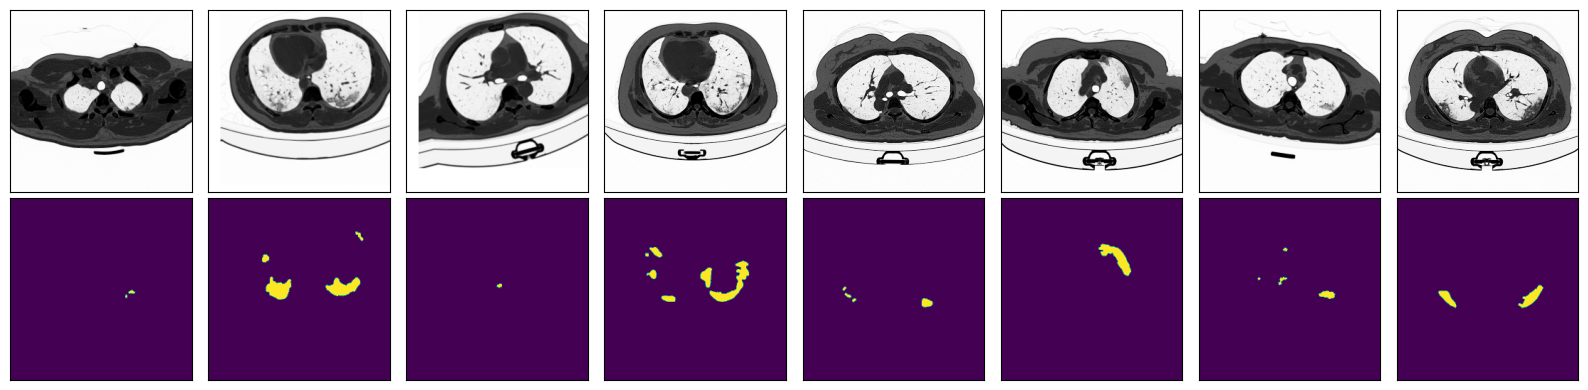

In [18]:
#os.mkdir('/kaggle/working/numpy_dataset')
    
save_dir = "/content/numpy_dataset/" # path where you want to save

if not os.path.exists(save_dir): # if there is no exist, make the path
    os.makedirs(save_dir)

np.save(save_dir+'x_train.npy', trainX)
np.save(save_dir+'y_train.npy', trainY)
np.save(save_dir+'x_val.npy', valX)
np.save(save_dir+'y_val.npy', valY)
np.save(save_dir+'x_test.npy', testX)
np.save(save_dir+'y_test.npy', testY)

print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)
    
x_train = np.load('/content/numpy_dataset/x_train.npy')
y_train = np.load('/content/numpy_dataset/y_train.npy')
x_val = np.load('/content/numpy_dataset/x_val.npy')
y_val = np.load('/content/numpy_dataset/y_val.npy')
    
train_dataset = Dataset(x_train, y_train, train_augs)
val_dataset = Dataset(x_val, y_val)


train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

visualize(*next(iter(train_dataloader)))

In [19]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    #conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

In [20]:
sm.set_framework('tf.keras')
sm.framework()

base_model = sm.Unet(backbone_name=BACKBONE,
                  encoder_weights='imagenet',
                  classes=CLASSES, 
                  activation=ACTIVATION)

dense_model = Sequential([Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
                        Conv2D(3, (1, 1)),  # map N channels data to 3 channels
                        base_model])

#dense_model = UNet((IMG_SIZE, IMG_SIZE, CHANNELS), CLASSES, dropout_rate=0.0, batch_norm=True)
    
dense_model.summary()
    
dense_model.compile(optimizer = Adam(learning_rate = LEARNING_RATE),
                          loss = CROSSENTROPY, metrics = [f1_score, f2_score, iou_score, precision, recall, 'acc', jaccard_loss, dice_loss, binary_focal_loss, bce_dice_loss, bce_jaccard_loss, binary_focal_dice_loss, binary_focal_jaccard_loss], run_eagerly= True)

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 3)       6         
                                                                 
 model (Functional)          (None, None, None, 1)     23752273  
                                                                 
Total params: 23,752,279
Trainable params: 23,748,247
Non-trainable params: 4,032
_________________________________________________________________


In [21]:
dense_model.load_weights('/kaggle/input/unet-vgg16-nosplit-notseg-final/U-Net with VGG16 Backbone_15_fold_5_Normalized_WithSome_NoSplit_NotSegmented/models/model_5.h5')

In [22]:
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO))
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/metrics')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/models')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/f1score_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/f2score_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/iou_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/dice_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/jaccard_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/binary_focal_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/bce_dice_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/bce_jaccard_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/binary_focal_dice_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/binary_focal_jaccard_loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/acc_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/loss_figure')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/val_images')
os.mkdir('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/test_images')

In [23]:
preds = dense_model.evaluate(val_dataloader)

8/8 [==============================] - 14s 244ms/step - loss: 0.0073 - f1-score: 0.8565 - f2-score: 0.8589 - iou_score: 0.7494 - precision: 0.8529 - recall: 0.8606 - acc: 0.9962 - jaccard_loss: 0.2506 - dice_loss: 0.1435 - binary_focal_loss: 0.0020 - binary_crossentropy_plus_dice_loss: 0.1508 - binary_crossentropy_plus_jaccard_loss: 0.2579 - binary_focal_loss_plus_dice_loss: 0.1455 - binary_focal_loss_plus_jaccard_loss: 0.2525


In [24]:
preds = dense_model.predict(valX)
prediction = preds > 0.5

9/9 [==============================] - 4s 472ms/step


In [25]:
res_f1score = sm.metrics.f1_score(valY, preds).numpy()
res_f2score = sm.metrics.f2_score(valY, preds).numpy()
res_iouscore = sm.metrics.iou_score(valY, preds).numpy()
res_precision = sm.metrics.precision(valY, preds).numpy()
res_recall = sm.metrics.recall(valY, preds).numpy()
res_dice_loss = sm.losses.dice_loss(valY, preds).numpy()
res_jaccard_loss = sm.losses.jaccard_loss(valY, preds).numpy()
res_binary_focal_loss = sm.losses.binary_focal_loss(valY, preds).numpy()
res_bce_dice_loss = sm.losses.bce_dice_loss(valY, preds).numpy()
res_bce_jaccard_loss = sm.losses.bce_jaccard_loss(valY, preds).numpy()
res_binary_focal_dice_loss = sm.losses.binary_focal_dice_loss(valY, preds).numpy()
res_binary_focal_jaccard_loss = sm.losses.binary_focal_jaccard_loss(valY, preds).numpy()

In [26]:
print(res_f1score)
print(res_f2score)
print(res_iouscore)
print(res_precision)
print(res_recall)
print(res_dice_loss)
print(res_jaccard_loss)
print(res_binary_focal_loss)
print(res_bce_dice_loss)
print(res_bce_jaccard_loss)
print(res_binary_focal_dice_loss)
print(res_binary_focal_jaccard_loss)

0.8556853
0.8552565
0.747771
0.85640085
0.8549709
0.1443147
0.25222898
0.001892628
0.15144958
0.25936386
0.14620733
0.2541216


In [27]:
val_data=[]
val_data.append([res_f1score, res_f2score, res_iouscore, res_precision, res_recall, res_dice_loss, res_jaccard_loss, res_binary_focal_loss, res_bce_dice_loss, res_bce_jaccard_loss, res_binary_focal_dice_loss, res_binary_focal_jaccard_loss])

In [28]:
validation_results = pd.DataFrame(val_data, columns = ['Val F1-Score', 'Val F2-Score', 'Val IOU-Score', 'Val Precision','Val Recall','Val Dice Loss','Val Jaccard Loss','Val Binary Focal Loss','Val BCE Dice Loss','Val BCE Jaccard Loss','Val Binary Focal Dice Loss','Val Binary Focal Jaccard Loss'])

In [29]:
validation_results.to_excel("/kaggle/working/"+str(MODEL_NAME)+'_'+str(FOLDNO)+"/metrics/validation_results.xlsx",
             sheet_name='Sheet1') 

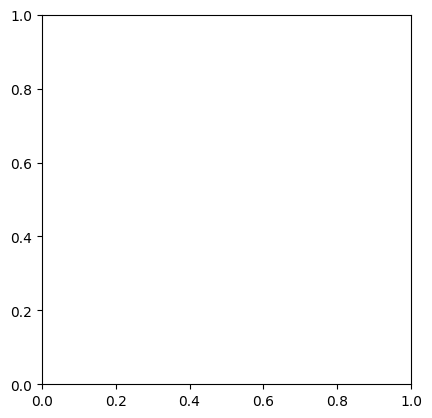

In [30]:
for i in range(0,len(valX)):
    plt.imshow(valX[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/val_images/val_img_orig_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()
    plt.imshow(valY[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/val_images/val_img_gt_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/val_images/val_img_pred_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()
    plt.imshow(prediction[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/val_images/val_img_bin_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()

In [31]:
test_dataset = Dataset(testX, testY)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
preds = dense_model.evaluate(test_dataloader)

15/15 [==============================] - 4s 249ms/step - loss: 0.0830 - f1-score: 0.5903 - f2-score: 0.5103 - iou_score: 0.4234 - precision: 0.8313 - recall: 0.4695 - acc: 0.9838 - jaccard_loss: 0.5766 - dice_loss: 0.4097 - binary_focal_loss: 0.0202 - binary_crossentropy_plus_dice_loss: 0.4927 - binary_crossentropy_plus_jaccard_loss: 0.6595 - binary_focal_loss_plus_dice_loss: 0.4299 - binary_focal_loss_plus_jaccard_loss: 0.5968


In [33]:
preds = dense_model.predict(testX)
prediction = preds > 0.5

16/16 [==============================] - 5s 314ms/step


In [34]:
res_f1score = sm.metrics.f1_score(testY, preds).numpy()
res_f2score = sm.metrics.f2_score(testY, preds).numpy()
res_iouscore = sm.metrics.iou_score(testY, preds).numpy()
res_precision = sm.metrics.precision(testY, preds).numpy()
res_recall = sm.metrics.recall(testY, preds).numpy()
res_dice_loss = sm.losses.dice_loss(testY, preds).numpy()
res_jaccard_loss = sm.losses.jaccard_loss(testY, preds).numpy()
res_binary_focal_loss = sm.losses.binary_focal_loss(testY, preds).numpy()
res_bce_dice_loss = sm.losses.bce_dice_loss(testY, preds).numpy()
res_bce_jaccard_loss = sm.losses.bce_jaccard_loss(testY, preds).numpy()
res_binary_focal_dice_loss = sm.losses.binary_focal_dice_loss(testY, preds).numpy()
res_binary_focal_jaccard_loss = sm.losses.binary_focal_jaccard_loss(testY, preds).numpy()

In [35]:
print(res_f1score)
print(res_f2score)
print(res_iouscore)
print(res_precision)
print(res_recall)
print(res_dice_loss)
print(res_jaccard_loss)
print(res_binary_focal_loss)
print(res_bce_dice_loss)
print(res_bce_jaccard_loss)
print(res_binary_focal_dice_loss)
print(res_binary_focal_jaccard_loss)

0.6205441
0.5265023
0.44984692
0.8835799
0.47819006
0.37945592
0.5501531
0.020031651
0.4618346
0.63253176
0.39948758
0.5701847


In [36]:
test_data=[]
test_data.append([res_f1score, res_f2score, res_iouscore, res_precision, res_recall, res_dice_loss, res_jaccard_loss, res_binary_focal_loss, res_bce_dice_loss, res_bce_jaccard_loss, res_binary_focal_dice_loss, res_binary_focal_jaccard_loss])

In [37]:
test_results = pd.DataFrame(test_data, columns = ['Test F1-Score', 'Test F2-Score', 'Val IOU-Score', 'Test Precision','Test Recall','Test Dice Loss','Test Jaccard Loss','Test Binary Focal Loss','Test BCE Dice Loss','Test BCE Jaccard Loss','Test Binary Focal Dice Loss','Test Binary Focal Jaccard Loss'])

In [38]:
test_results.to_excel("/kaggle/working/"+str(MODEL_NAME)+'_'+str(FOLDNO)+"/metrics/test_results.xlsx",
             sheet_name='Sheet1') 

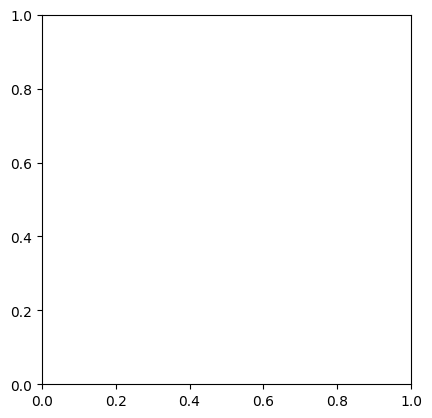

In [39]:
for i in range(0,len(testX)):
    plt.imshow(testX[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/test_images/test_img_orig_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()
    plt.imshow(testY[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/test_images/test_img_gt_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/test_images/test_img_pred_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()
    plt.imshow(prediction[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('/kaggle/working/'+MODEL_NAME+'_'+str(FOLDNO)+'/test_images/test_img_bin_'+str(i)+'.png', bbox_inches='tight')
    plt.cla()

In [40]:
!zip -r Model_fold_5.zip '/kaggle/working/U-Net with VGG16 Backbone_5'

  adding: kaggle/working/U-Net with VGG16 Backbone_5/ (stored 0%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/iou_figure/ (stored 0%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/f1score_figure/ (stored 0%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/ (stored 0%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_orig_240.png (deflated 2%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_orig_215.png (deflated 2%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_orig_466.png (deflated 2%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_gt_154.png (deflated 37%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_bin_240.png (deflated 17%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_orig_254.png (deflated 2%)
  adding: kaggle/working/U-Net with VGG16 Backbone_5/test_images/test_img_orig_441.png (defla

In [43]:
print('AAAA')

AAAA
